We will be using the MNIST dataset at this kaggle link:
https://www.kaggle.com/datasets/animatronbot/mnist-digit-recognizer/code

# **PART 1**

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Let's see how much data we are working with

In [8]:
df = pd.read_csv("/content/train.csv")

In [10]:
w = len(df)
w

42000

In [11]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since we can see that it matches, let us build our Neural Network class. It will contain:

*   An **init** function where we initialize our weights and bias layers.
*   The **cost** function so that we can see how our network's cost changes over time
*   A **ReLU** function to activate our layers
*   A **Softmax** function to convert our layer output values to be between 0 and 1
*   A **forward** function to do forward propagation
*   A **backward** function to do backward propagation
*   A **train** function to automatically do gradient descent with each X and y input
*   A **predict** function that automatically returns the model's prediction for an X input.

(I was not sure if we could simply write loss.backward if I used pytorch or tensorflow() in our backprop algorithm so I wrote everything out using numpy)


In [127]:
class NeuralNetwork:
  def __init__(self, lr, input, hidden, output):
    self.lr = lr
    self.W1 = np.random.randn(hidden, input)    # This is the weights of our first layer, in this program, of the shape (32, 784)
    self.b1 = np.random.randn(hidden, 1)        # This is the bias of our first layer, in this program, of the shape (32, 1)
    self.W2 = np.random.randn(output, hidden)   # This is the weights of our second layer, in this program, of the shape (10, 32)
    self.b2 = np.random.randn(output, 1)        # This is the bias of our second layer, in this program, of the shape (10, 1)

  def cost(self, y, pred):
    costs = abs(y-pred.reshape(-1))                         # We are using a standard mean absolute error cost function
    return np.mean(costs)

  def ReLU(self, l):
    return np.maximum(0, l)

  def Softmax(self, l):
    return np.exp(l)/np.sum(np.exp(l))

  def forward(self, input):
    input = input.reshape(self.W1.shape[1], -1)                     # We reshape the input to be 2 dimensional (just for syntax)
    self.output1 = self.W1.dot(input)/len(self.W1) + self.b1        # First input this into our first layer. We divide by the length to avoid large exponents
    self.layer1 = self.ReLU(self.output1)                           # ReLU activation to pass only the effective weights
    self.output2 = self.W2.dot(self.layer1)/len(self.W2) + self.b2  # second layer

    return self.Softmax(self.output2)                               # Now we pass the final output through Softmax to get our translated output

  def backward(self, X, y, pred):
    X = X.reshape(self.W1.shape[1], -1)
    y = y.reshape(self.W2.shape[0], -1)       # We reshape the input to be 2 dimensional (just for syntax)
    m = len(y)                                # the length of y will be used to average out arrays later

    z2 = pred - y
    dw2 = 1/m * z2.dot(self.layer1.T)         # We find the gradients for the second layer for both the weights and biases
    db2 = 1/m * np.sum(z2, 1)
    db2 = db2.reshape(-1, 1)

    z1 = self.W2.T.dot(z2) * (self.output1 > 0)
    dw1 = 1/m * z1.dot(X.T)                   # We find the gradients for the first layer for both the weights and biases
    db1 = 1/m * np.sum(z1, 1)
    db1 = db1.reshape(-1, 1)

    self.W1 -= self.lr*dw1      # Update the weights and biases
    self.b1 -= self.lr*db1
    self.W2 -= self.lr*dw2
    self.b2 -= self.lr*db2

  def train(self, X, y):
    pred = self.forward(X.T)
    self.backward(X.T, y.T, pred)

    return self.cost(y, pred)

  def predict(self, input):
    return np.argmax(self.forward(input))

# **PART 2**

**TASK 1**

I used "*Efficient BackProp*" by Yann LeCunn, Leon Bottou, Genevieve B. Orr, and Klaus-Robert Muller. (*In our Submitty Course Materials*)

(Special thanks to the youtube video "Building a neural network FROM SCRATCH (no Tensorflow/Pytorch, just numpy & math)" by Samson Zhang whomst I watched a long time ago.)

**init**
We can all understand why we used numpy arrays of random float values. np.random.randn() gives us random values between -0.5 and 0.5 allowing us to make random weights for our matrices.

**Forward Prop**
The forward propagation is simple, we do matrix multiplication or dot multiplication to change our layers (and adding our biases) until we have the output shape that we want. In between our layers, we have a ReLU activation. This is an important step since otherwise, passing our input through a (m by n) matrix layer and then  a (n by t) matrix layer would be no different from doing a (m by t) matrix layer that is the product of both which provides less diversity.
The ReLU activation layer simply changes the negative values to 0 since we are looking for weights that will make positive growth. Negative values are inevitably going to be ignorable by the end of the forward propagation, thus we can save computational power by converting it to 0 and saving our computer the multiplication process.

After we do a dot product with our layer, we divide our output by the length of that layer. This is because our outputs will inevitably turn out to be very huge if left to grow unchecked and since we have to a softmax with np.exp(), large values will return inf and mess up our code. This is our **normalization**

**BackProp**
The backward propagation is a little bit harder to understand but once the underlying process is realized, it is simple. We find the gradient for our second layer by finding the difference between our predicted values and actual values and doing a dot product with our output for the first layer since that was what produced our final output. The biases for our second layer is simply the sum of the differences of our predicted and actual, or the number that would get us closest to our actual.

The gradient for our first layer follows the same process as the second but this time, we use our input X transposed in our dot multiplication since that was what produced our output for the first layer. Additionally, we multiply that by an array of 1's and 0's corresponding to whether the values of the outputs of our first layer was positive or negative for the same reason we use ReLU, we only want to focus on the values that make positive values.

**TASK 2**

We will:
*   Perform the train-val-test split
*   Visualize our data
*   Implement the forward/backward propagation (model training)
*   Compute the costs
*   Get the final accuracy for the test set

So we have 42,000 rows of 784 columns of data. Let us split that into a train, val, test set respectively into a 70%, 15%, and 15% for all data respectively.

In [12]:
# PERFORMING THE TRAIN VAL TEST SPLIT
train = df.loc[:w*0.7]
val = df.loc[w*0.7:w*0.85].reset_index(drop = True)
test = df.loc[w*0.85:].reset_index(drop = True)

We should check up on our data and make sure that it is well divided. Let's try seeing how much 0's, 1's, through 9's we have in each set

In [13]:
frequency = [[0]*3 for i in range(10)]
for num, freq in train.label.value_counts().items():  frequency[num][0] = freq
for num, freq in val.label.value_counts().items():    frequency[num][1] = freq
for num, freq in test.label.value_counts().items():   frequency[num][2] = freq

In [154]:
for i in range(10): print("Number of ", i, "'s :   ", frequency[i][0], '\t ', frequency[i][1], '\t', frequency[i][2])

Number of  0 's :    2869 	  618 	 645
Number of  1 's :    3275 	  696 	 713
Number of  2 's :    2951 	  630 	 597
Number of  3 's :    3034 	  669 	 648
Number of  4 's :    2888 	  545 	 639
Number of  5 's :    2660 	  588 	 547
Number of  6 's :    2910 	  592 	 635
Number of  7 's :    3069 	  701 	 631
Number of  8 's :    2828 	  611 	 624
Number of  9 's :    2916 	  651 	 621


Each set has a balanced variance of each number. Now Let us convert each set into X's and y's that the model can accept. For the y values, we'll be converting them into one hot encodings.

In [21]:
train_X, train_y = np.array(train.iloc[:, 1:]), np.zeros((len(train), 10))
train_y[np.arange(len(train)), train.label] = 1

val_X, val_y = np.array(val.iloc[:, 1:]), np.zeros((len(val), 10))
val_y[np.arange(len(val)), val.label] = 1

test_X, test_y = np.array(test.iloc[:, 1:]), np.zeros((len(test), 10))
test_y[np.arange(len(test)), test.label] = 1

Let's try visualizing the data by plotting the x points and comparing it to the y values.

Expected drawing:  1


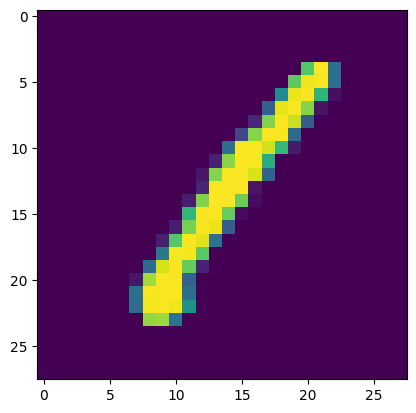

It works!


In [46]:
print("Expected drawing: ", np.argmax(train_y[0]))
plt.figure()
plt.imshow(train_X[0].reshape(28, 28))
plt.show()
print("It works!")

In [142]:
model = NeuralNetwork(2e-5, 784, 32, 10)

In [143]:
EPOCHS = 30
cost_list = []
for e in range(EPOCHS):
  cost = 0
  for i, (_x, _y)  in enumerate(zip(train_X, train_y)):     # Note: I know that I have set up my code to be able to take in batches
                                                            # of information at once but I am doing it this way out of preference
    cost += model.train(_x, _y)     # Since we have set up train to return the cost of each forward progress, let us save the costs to plot it out

    if i%20 == 0 and i != 0:
      cost_list.append(cost/20)    # We average out the costs over every 100 iterations to not be confused with the occasional outlier
      cost = 0

  acc = 0
  for i, (_x, _y) in enumerate(zip(val_X, val_y)):
    acc += _y[model.predict(_x)]
  print(e, '\t', acc/len(val))      # We print the accuracy of the model on the val set every epoch to see the progress we are making

0 	 0.5530868116172036
1 	 0.5819711156959213
2 	 0.6197428979527059
3 	 0.6500555467386129
4 	 0.6737025868909697
5 	 0.6949690525313442
6 	 0.7111569592128234
7 	 0.727186160926837
8 	 0.7414696079987304
9 	 0.7490874464370735
10 	 0.7565465799079512
11 	 0.7641644183462942
12 	 0.7711474369147754
13 	 0.7779717505157911
14 	 0.7833677194096175
15 	 0.7892398032058403
16 	 0.7946357720996667
17 	 0.7986033962863037
18 	 0.8024123155054753
19 	 0.8073321694969052
20 	 0.8111410887160768
21 	 0.8135216632280591
22 	 0.818441517219489
23 	 0.8220917314711951
24 	 0.8251071258530392
25 	 0.8263767655927631
26 	 0.8282812252023488
27 	 0.8298682748770037
28 	 0.8332010791937787
29 	 0.8344707189335027


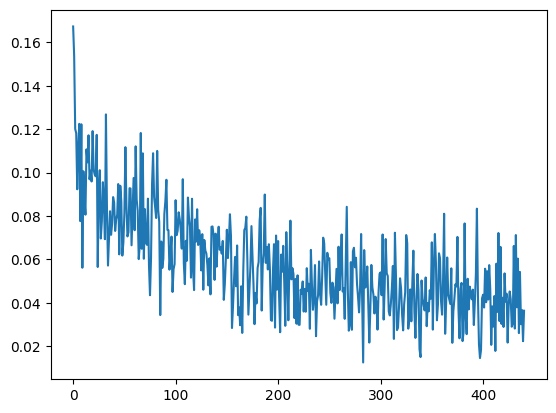

In [149]:
plt.plot(cost_list[::100])
plt.show()

In [59]:
int(len(cost_list)/200)

4410

In [43]:
model.predict(train_X[9].T)

3

Now, let's compute our final accuracy for our test set

In [153]:
acc = 0
for i, (_x, _y) in enumerate(zip(test_X, test_y)):
  acc += _y[model.predict(_x)]
print(acc/len(test))

0.8377777777777777


We got a respectable 83% accuracy.

**TASK 3**

The hyperparameters I used were rather standard and very scant since I coded the whole thing with numpy instead of using pytorch or tensorflow. The few that I used include:
*   Learning rate
*   The number of neurons used in the model

I selected a very reasonable 2e-5 for the learning rate. I had tinkered with various values ranging from 1e-3 to 5e-6. I thought that 1e-5 was the most standard value but chose to use 2e-5 to speed up the training process.

The numbers 784 and 10 are inevitable dimensions for the model (unless I got rid of some pixel data along the sides of the X inputs's). I began the training process by using 64 as the middle layer dimension as (784, 64) and (64, 10). However, I switched to 32 as I saw relatively little change in accuracy while effectively halving the training time. Using 64 would have been objectively better as more neurons can hold more information. However, I believe that the best way to increase accuracy would be to add one more layer in the middle, a (64, 64) layer to give one more check over the input data, but I was constrained by the rules of this project.

I used normalization or I suppose you could call it regularization in the middle of forward propagation. Having values too large going into Softmax caused an exponent to the power of numbers in the thousands returning inf and causing my weights and biases to turn into nan's. Thus, regularization was absolutely essential.

I used the most standard gradient descent algorithm, done by HAND. It was an awful long process. It was done using MATH and CALCULUS. It was absolutely essential as it is the heart behind neural network learning and I would have liked to know how Adam or RMSProp worked but I had not so I could not use it.
